In [1]:
import sys
import fire
import pandas as pd 
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
import datetime as dt
from pytz import timezone
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path
import csv

# Import profiler functions.
from profiler import get_info
from profiler import qualification
from profiler import risk_profile

# Import data retrieval.
from data_retrieval import import_asset_data
from data_retrieval import format_close_price
from data_retrieval import jupyter_import_csv

# Import calculation functions.
from calculations import calculate_average_annual_returns
from calculations import calculate_average_annual_volatility
from calculations import calculate_daily_returns
from calculations import calculate_sharpe_ratio
from calculations import calculate_portfolio_return
from calculations import calculate_portfolio_volatility
from calculations import calculate_portfolio_sharpe_ratio

# Import Monte-Carlo Simulation tools.
from MCForcastTools import MCSimulation

# Import Visualizer functions.
from visualizer import create_MC_object
from visualizer import run_MC_Simulation
from visualizer import retrieve_MC_summary

# Import Efficient Frontier functions.
from efficient_frontier import generate_random_portfolios
from efficient_frontier import determine_optimal_portfolio
from efficient_frontier import plot_efficient_frontier

In [2]:
# Tickers.
timeframe = "1D"
tickers = ["SPY", "AGG", "BTC"]

In [3]:
# Weights per client risk profile.  
risk_profile_weights = {"conservative" : [0.1, 0.9, 0.0], "moderately conservative" : [0.25, 0.7, 0.05], 
                        "moderate" : [0.6, 0.3, 0.1], "moderately aggressive" : [0.75, 0.2, 0.05],
                        "aggressive" : [0.8, 0.0, 0.2]}
                  

In [4]:
# Clientele information; (hardcoded since questionary cannot run in Jupyter Notebook)
cash = 10000
assets = 20000
income = 75000
liquidity = 50000

# Calculate client's net worth.
net_worth = qualification(cash, assets, income, liquidity)

# Determine client's risk profile (hardcoded since questionary cannot run in Jupyter Notebook)
risk_prof = "moderately aggressive"

Net worth: 55000
You are able to invest: 55000


## Retrive Data and Clean Up

In [5]:
raw_data_close_df = jupyter_import_csv()
raw_data_close_df.head(-5)

,SPY,AGG,BTC
Date,,,
2015-12-31,203.87,108.01,430.35
2016-01-01,NaN,NaN,435.66
2016-01-02,NaN,NaN,435.40
2016-01-03,NaN,NaN,431.91
2016-01-04,201.02,107.97,433.85
...,...,...,...
2020-12-21,367.86,117.79,22729.40
2020-12-22,367.24,117.96,23825.90
2020-12-23,367.57,117.88,23224.30


In [6]:
# Retrieve daily returns and N/A for each asset
daily_returns_df = calculate_daily_returns(raw_data_close_df)
daily_returns_df.head(-5)

,SPY,AGG,BTC
Date,,,
2016-01-01,0.000000,0.000000,0.012339
2016-01-02,0.000000,0.000000,-0.000597
2016-01-03,0.000000,0.000000,-0.008016
2016-01-04,-0.013979,-0.000370,0.004492
2016-01-05,0.001691,0.000463,-0.001176
...,...,...,...
2020-12-21,-0.003575,0.000000,-0.034025
2020-12-22,-0.001685,0.001443,0.048241
2020-12-23,0.000899,-0.000678,-0.025250


In [7]:
# Retrieve average annual returns for each asset for SPY, AGG, BTC
average_annual_returns_df = calculate_average_annual_returns(daily_returns_df)
print(average_annual_returns_df)

SPY    0.095445
AGG    0.013073
BTC    0.784863
dtype: float64


In [8]:
# Retrieve average annual volatility for SPY, AGG, BTC
average_annual_volatility_df = calculate_average_annual_volatility(daily_returns_df)
print(average_annual_returns_df)

SPY    0.095445
AGG    0.013073
BTC    0.784863
dtype: float64


## Calculate Portfolio Return, Volatility, and Sharpe Ratio per Profile

In [9]:
# Calculate portfolio returns, volatility and Sharpe Ratio per risk profile.
portfolio_return = calculate_portfolio_return(daily_returns_df, risk_profile_weights[risk_prof])
portfolio_volatility = calculate_portfolio_volatility(daily_returns_df, risk_profile_weights[risk_prof])
portfolio_sharpe_ratio = calculate_portfolio_sharpe_ratio(portfolio_return, portfolio_volatility)

In [10]:
# Print portfolio metrics (5-year).
print("Portfolio Statistics per Client Risk Profile (5-Year)")
print("=====================================================")
print(f"Return = {portfolio_return * 100: .2f}%")
print(f"Volatility = {portfolio_volatility * 100: .2f}%")
print(f"Sharpe Ratio = {portfolio_sharpe_ratio: .2f}")
print(f"Weighting = [{risk_profile_weights[risk_prof][0]} (SPY), {risk_profile_weights[risk_prof][1]} (AGG), {risk_profile_weights[risk_prof][2]} (BTC)]")
print("-----------------------------------------------------")
print()

Portfolio Statistics per Client Risk Profile (5-Year)
Return =  11.34%
Volatility =  12.70%
Sharpe Ratio =  0.89
Weighting = [0.75 (SPY), 0.2 (AGG), 0.05 (BTC)]
-----------------------------------------------------



In [11]:
# Determine optimized portfolios.
portfolio_returns, portfolio_risk, sharpe_ratio_port, portfolio_weights = generate_random_portfolios(100, 3, daily_returns_df)
portfolio_metrics = [portfolio_returns, portfolio_risk, sharpe_ratio_port, portfolio_weights]
determine_optimal_portfolio(portfolio_metrics)


Portfolio with Greatest Sharpe Ratio
Returns =  19.15%
Sharpe Ratio =  0.14
Weighting = [ 0.30 (SPY),  0.50 (AGG), 0.20 (BTC)]
-----------------------------------------------------

Portfolio with Least Risk
Returns =  7.41%
Sharpe Ratio =  0.06
Weighting = [ 0.08 (SPY),  0.85 (AGG), 0.07 (BTC)]
-----------------------------------------------------



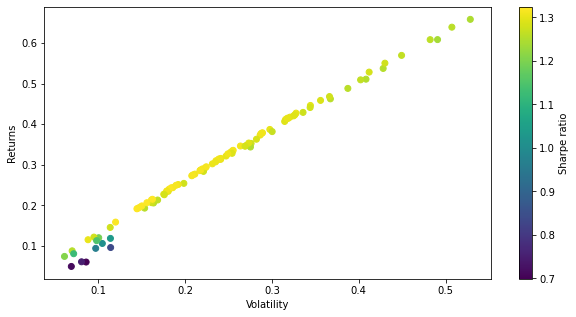

In [12]:
mod_agg_eff_frontier = plot_efficient_frontier(portfolio_risk, portfolio_returns)